In [43]:
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from importlib import import_module
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, CenterCrop, ColorJitter,RandomRotation,RandomCrop, RandomHorizontalFlip, RandomErasing
import torchvision.datasets as dset
from dataset import MaskSplitByProfileDataset, BaseAugmentation
from PIL import Image

In [78]:
# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# 데이터셋의 경로
# dataroot = "/opt/ml/input/data/train/images"

# dataloader에서 사용할 쓰레드 수
workers = 0

# 배치 크기
batch_size = 128
# 이미지의 크기입니다. 모든 이미지들은 transformer를 이용해 64로 크기가 통일됩니다.
# image_size = 64
image_size = 224
# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 3
# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100
# 생성자를 통과하는 특징 데이터들의 채널 크기
# ngf = 64
ngf = 224
# 구분자를 통과하는 특징 데이터들의 채널 크기
# ndf = 64
ndf = 224
# 학습할 에폭 수
num_epochs = 9999
# 옵티마이저의 학습률
lr = 0.0002
# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5
# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='MaskSplitByProfileDataset', help='dataset augmentation type (default: MaskSplitByProfileDataset)')
parser.add_argument('--augmentation', type=str, default='BaseAugmentation', help='data augmentation type (default: BaseAugmentation)')
dataset_module = getattr(import_module("dataset"), 'MaskSplitByProfileDataset')  # default: MaskBaseDataset
dataset = dataset_module(data_dir='/opt/ml/input/data/train/images',)

transform_module = getattr(import_module("dataset"), 'BaseAugmentation')  # default: BaseAugmentation
transform = transform_module(
        resize=[64,64],
        mean=dataset.mean,
        std=dataset.std,
    )
dataset.set_transform(transform)
# dataloader를 정의해봅시다
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  999


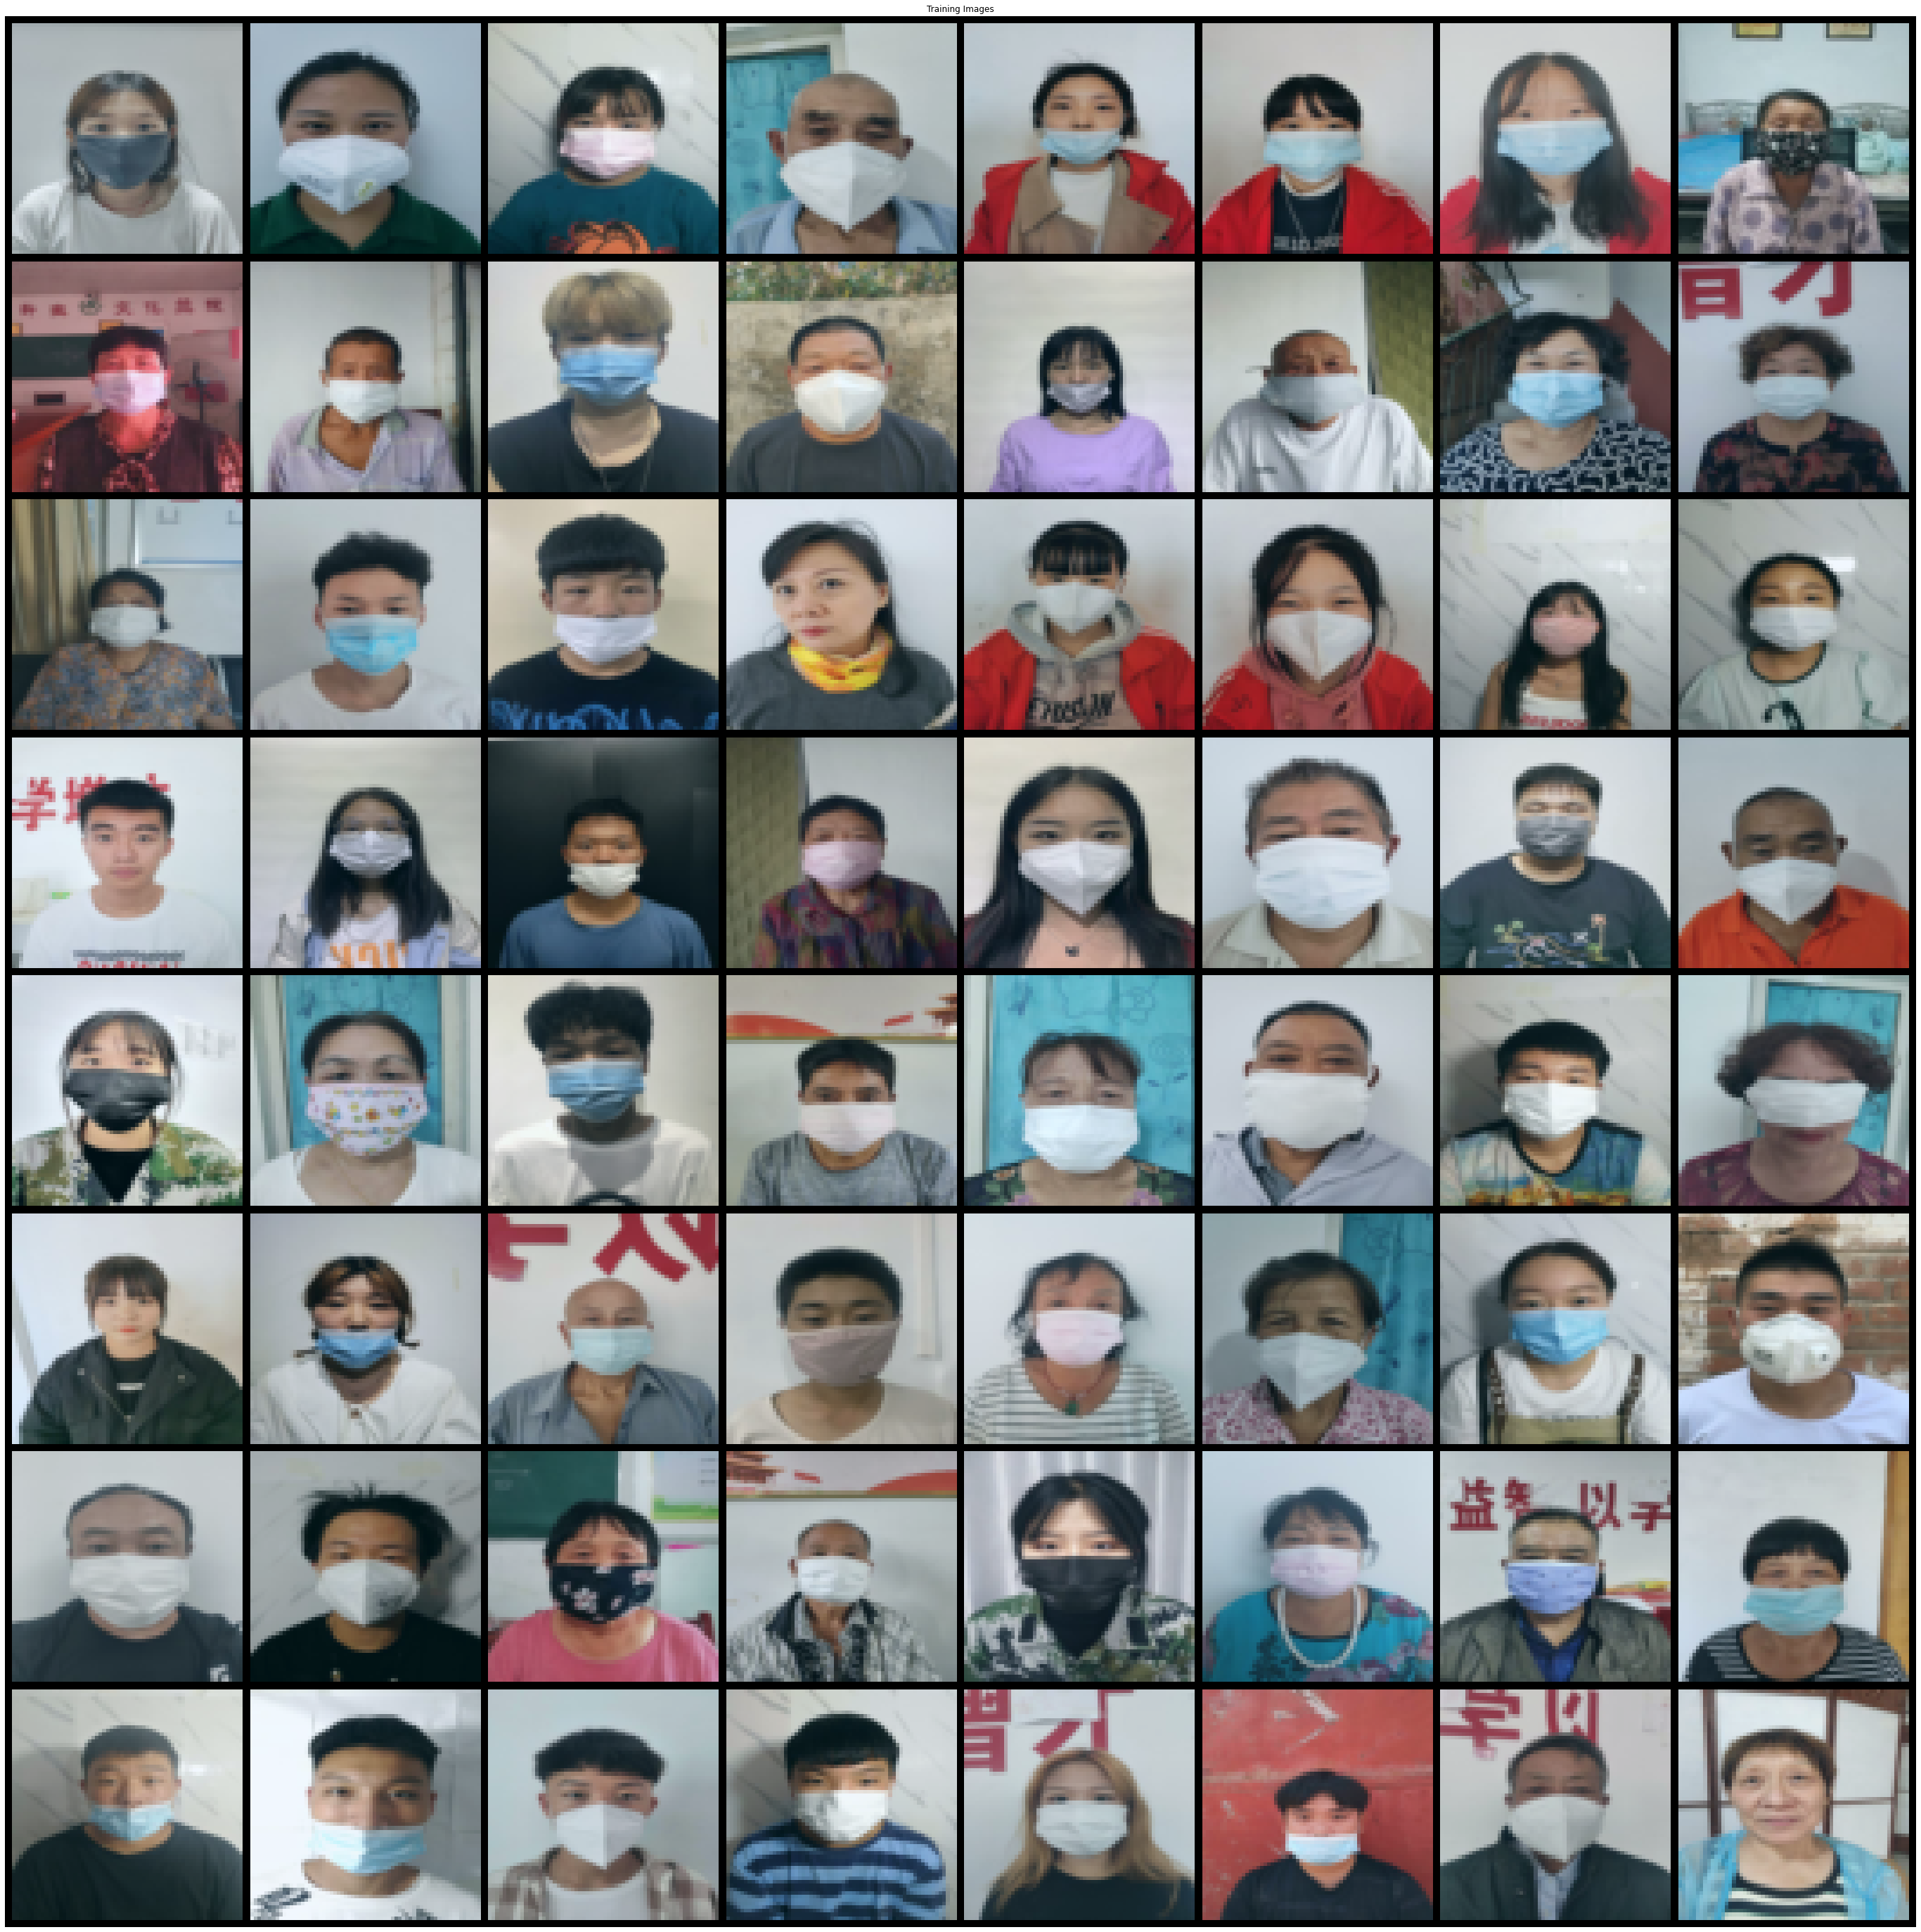

In [45]:
# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(dataloader))
plt.figure(figsize=(50,50))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [79]:
# netG와 netD에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d( nz * 3.5, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 3.5 * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 3.5 * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 3.5 * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf * 3.5, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# 구분자 코드

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 (nc) x 64 x 64 입니다
            nn.Conv2d(nc * 3.5, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf) x 32 x 32
            nn.Conv2d(ndf * 3.5, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 3.5 * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 3.5 * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 3.5 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

In [80]:
# 생성자를 만듭니다
netG = Generator(ngpu).to(device)

# 필요한 경우 multi-gpu를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# weight_init 함수를 적용시킵니다
netG.apply(weights_init)

# 모델의 구조를 출력합니다
print('netG : ',netG)

# 구분자를 만듭니다
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-gpu를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# weight_init 함수를 적용시킵니다
netD.apply(weights_init)

# 모델의 구조를 출력합니다
print('netD : ',netD)

TypeError: new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:
 * (*, torch.device device)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [48]:
# BCELoss 함수의 인스턴스를 생성합니다
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [75]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu().numpy()[i][0]
                print(fake.shape)
#                 plt.imshow(np.reshape(fake, (64,64)))
                plt.imshow(np.reshape(fake, (224,224)))
                plt.savefig(f'/opt/ml/v2/output/gan_test/epoch_{epoch}_test_gan.png')
            # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        

        iters += 1


Starting Training Loop...
[0/9999][0/3101]	Loss_D: 0.0939	Loss_G: 5.9739	D(x): 0.9988	D(G(z)): 0.0685 / 0.0096
(64, 64)


ValueError: cannot reshape array of size 4096 into shape (224,224)

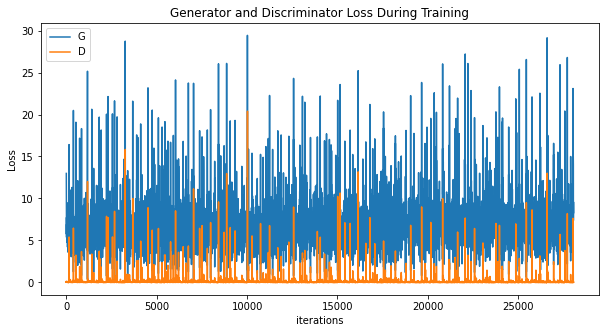

In [52]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig(f'/opt/ml/v2/output/gan_test/ganloss.png')

Animation size has reached 21146979 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


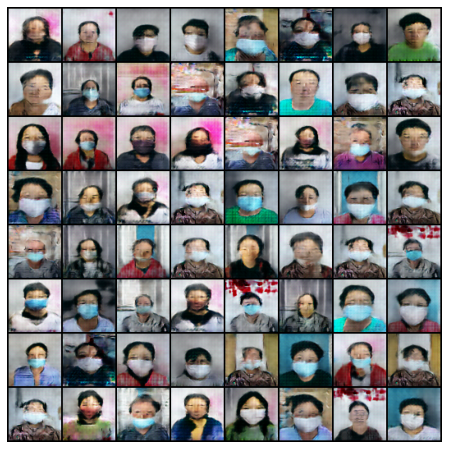

In [54]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

testfile = HTML(ani.to_jshtml())

In [56]:
print(type(testfile))

<class 'IPython.core.display.HTML'>
